# Data Exploration
This note book does some basic data exploration of the telco churn data. This is just to get a sense of what the data looks like and if there are any specific patterns that can be decerned. 

In step 1, the data is imported into the `default.telco_churn` table in hive. All new data accesses will go via hive.

In [8]:
# Load the data

from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("Telco Data Set")\
    .master("local[*]") \
    .getOrCreate()

telco_data_raw = spark.sql("SELECT * FROM default.telco_churn")
telco_data_raw.toPandas().head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.8 MB/s eta 0:00:0000:01


### Some Basic Spark DataFrame Operations
Spark Dataframes essentially allow you to express sql-like statements. 
We can filter, count, groupby etc. 

[Official Spark Documentation](http://spark.apache.org/docs/latest/sql-programming-guide.html)

In [10]:
# total number of customers in the dataset
telco_data_raw.count()

7043

In [11]:
# count of customers by internet service type 
telco_data_raw.groupby("InternetService").count().show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1526|
|            DSL| 2421|
+---------------+-----+



### Spark SQL Operations -  Working Directly with Dataframes
Using the `createOrReplaceTempView` functions allows you register a table (called a view) in Spark that lets use SQL syntax to make the queries.

In [12]:
telco_data_raw.createOrReplaceTempView("telco")
spark.sql("select distinct(Churn), count(*) from telco GROUP BY Churn").show()

+-----+--------+
|Churn|count(1)|
+-----+--------+
|   No|    5174|
|  Yes|    1869|
+-----+--------+



As you can see, there are 11 null values in the `Churn` column. The data needs to be cleaned before it can be used for any machine learning work. One way to clean the data in pyspark is to use `.filter()` function to identify non-null values with `isNotNull()`.

In [13]:
#Remove invalid data
telco_data = telco_data_raw.filter(telco_data_raw.Churn.isNotNull())

total_customers = telco_data.count()
churned_customers = telco_data.filter(telco_data.Churn == 'Yes').count()
remain_customers = telco_data.filter(telco_data.Churn == 'No').count()

"Customers total: {}, Churned : {}, Remained : {}".format(total_customers,churned_customers,remain_customers)

'Customers total: 7043, Churned : 1869, Remained : 5174'

## Data visualisation

The data vizualization workflow for large data sets is usually:

* Sample data so it fits in memory on a single machine.
* Examine single variable distributions.
* Examine joint distributions and correlations.
* Look for other types of relationships.

[DataFrame#sample() documentation](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sample)


In [14]:
#Note: toPandas() => brings data locally into a Pandas DataFrame
sample_data = telco_data.sample(False, 0.5, 83).toPandas()
sample_data.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,9237-HQITU,9305-CDSKC
gender,Female,Male,Male,Female,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,2,8
PhoneService,No,Yes,Yes,Yes,Yes
MultipleLines,No phone service,No,No,No,Yes
InternetService,DSL,DSL,DSL,Fiber optic,Fiber optic
OnlineSecurity,No,Yes,Yes,No,No


## Feature Distributions

We want to examine the distribution of our features, so start with them one at a time.

Seaborn has a standard function called [distplot()](https://seaborn.pydata.org/generated/seaborn.distplot.html) that allows us to easily examine the distribution of a column of a pandas dataframe or a numpy array.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


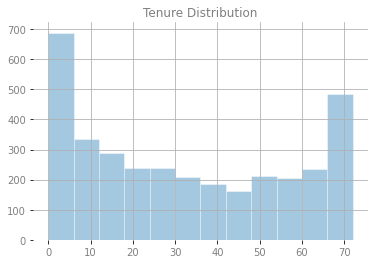

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.grid(b=None)
plt.title("Tenure Distribution",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)


def plotter():
    sns.distplot(sample_data['tenure'], kde=False, axlabel=False)
plotter()

We can examine feature differences in the distribution of our features when we condition (split) our data.

[BoxPlot documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot)

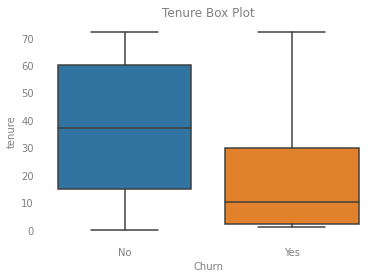

In [16]:
plt.grid(b=None)
plt.title("Tenure Box Plot",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.xlabel("",color='grey')
plt.ylabel("",color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

def plotter():
    sns.boxplot(x="Churn", y="tenure", data=sample_data)
plotter()

## Joint Distributions

Looking at joint distributions of data can also tell us a lot, particularly about redundant features. [Seaborn's PairPlot](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) let's us look at joint distributions for many variables at once.

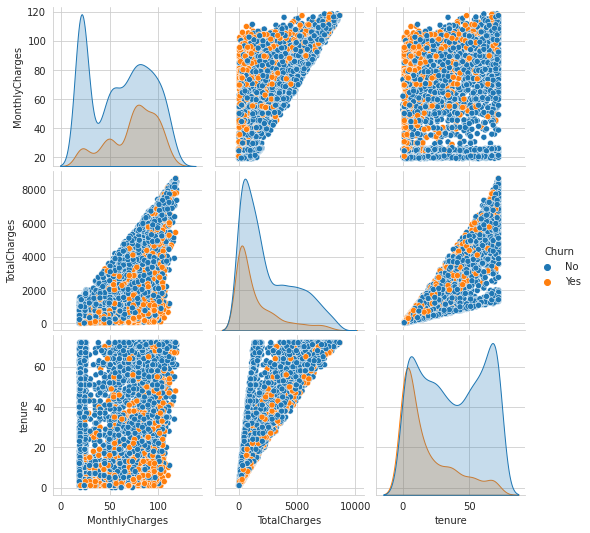

In [17]:
sns.set_style("whitegrid")
example_numeric_data = sample_data[["MonthlyCharges", "TotalCharges","tenure","Churn"]]
sns.pairplot(example_numeric_data, hue="Churn")

In [18]:
spark.stop()